# Bitcoin Twitter Sentiment Analysis

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import tweepy
import json
import re
import nltk
import gensim
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pymongo import MongoClient
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

## 2. Set up MongoDB

__The database will be used to stored all the downloaded tweets__

In [2]:
client = MongoClient('localhost', 27017)
db = client['twitterdb']
db['tweets'].drop()
col = db['tweets']

## 3. Set up Twitter API

__Twitter developer account can be set up here: https://developer.twitter.com/.__

In [3]:
# Define keys needed to connect
API_key = '<API_key>'
API_key_secret = '<API_key_secret>'

access_token = '<access_token>'
access_token_secret = '<access_token_secret>'

In [4]:
# Use tweepy to connect to the API
auth = tweepy.OAuthHandler(API_key, API_key_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [5]:
# Check if API connection is ok
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


## 4. Import tweets to MongoDB

In [6]:
# Define the key word(s) and number of tweets to search for
search_string = ['bitcoin', '-filter:retweets']
search_numbertweets = 10000

In [7]:
# Start collecting tweets from one week prior to today's date
today = datetime.now()
start = (today - timedelta(days=7)).strftime('%Y-%m-%d')
end = today.strftime('%Y-%m-%d')

# The Cursor objects handles pagination to iterate through the tweets to grab
tweets = tweepy.Cursor(api.search, q=search_string, count=5, lang="en", 
                       since=start, until=end).items(search_numbertweets)

# Loop through all tweets
while True:
    try:
        data = tweets.next()
    except StopIteration:
        break
    # Convert from JSON format to Python dict
    jsoned_data = json.dumps(data._json)
    tweet = json.loads(jsoned_data)
    # Insert into the database
    col.insert_one(tweet)

In [8]:
# Call the find() method without parameters to return all documents 
# incl. all of their fields from the collection and store in a df
documents = col.find()
df = pd.DataFrame(list(documents))

## 5. Preprocess tweets

__Define a class that preprocesses every tweet before analyzing them. Preprocessing includes:__
- __Remove whitespaces__: Removes all trailing whitespaces at the end of the tweet
- __Filter alphabetic__: Encodes as ascii then decodes as ascii to remove emojis, etc.
- __Lowercase__: Sentiment analysis should disregard any uppercase duplicates
- __Lemmatize__: Finally apply nltk's lemmatize to group together different inflected forms of a word

In [9]:
class TweetPreprocessor:
    
    """
    Input:
        Downloaded tweets from the Twitter API
    
    Attributes:
        df : dataframe
            A dataframe containing the collected tweets
    
    Output:
        A cleaned dataframe with the collected tweets
        
    """
    
    # Instantiate the WordNetLemmatizer as a class attribute
    lemmatizer = WordNetLemmatizer()   
    
    def __init__(self, df):
        self.df = df
    
    def __remove_whitespaces(self):
        """ Replaces any part of the tweet containing duplicate whitespaces with a single space """
        self.df['text'] = self.df['text'].map(lambda x: re.sub('\s+', ' ', str(x)).strip())

    def __filter_alphabetic(self):
        """ Removes emojis, etc. by first encoding and then decoding the tweet as ascii """
        self.df['text'] = self.df['text'].map(lambda x: x.encode('ascii', 'ignore').decode('ascii', 'ignore'))
    
    def __lowercase(self):
        """ Change all characters in the tweet to lowercase """
        self.df['text'] = self.df['text'].map(lambda x: x.lower() if isinstance(x, str) else x)
        
    def __lemmatize(self):
        """ 
        Transform the tweet to group together different inflected types of words by mapping their
        POS tag (part of speech) to one of four word classes and then applying the lemmatizer
        """
        def get_wordnet_pos(word):
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                        "N": wordnet.NOUN,
                        "V": wordnet.VERB,
                        "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)
        
        self.df['lemmatized_text'] = self.df['text'].apply(
            lambda x: ' '.join(self.lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)))
        
        return self.df
    
    def preprocess_data(self):
        self.__remove_whitespaces()
        self.__filter_alphabetic()
        self.__lowercase()
        self.__lemmatize()
        
        return self.df

In [10]:
# Instantiate a new TweetProcessor with the df containing all the tweets
tp = TweetPreprocessor(df)

In [11]:
# Apply the preprocessing on the tweets
df = tp.preprocess_data()
df.head(3)

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status,lemmatized_text
0,5f6caf5059164b2d5632dea8,Wed Sep 23 23:59:59 +0000 2020,1308919069991673861,1308919069991673861,rt @the_h4lf_50ul: really like the look of the...,False,"{'hashtags': [{'text': 'Tezos', 'indices': [11...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,False,en,NaN,NaN,NaN,NaN,rt @ the_h4lf_50ul : really like the look of t...
1,5f6caf5059164b2d5632dea9,Wed Sep 23 23:59:59 +0000 2020,1308919068141981697,1308919068141981697,#investing 181.1% in this optimal #crypto port...,True,"{'hashtags': [{'text': 'Investing', 'indices':...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.nalint.com/crypto"" rel=""no...",NaN,...,2,False,False,False,en,NaN,NaN,NaN,NaN,# invest 181.1 % in this optimal # crypto port...
2,5f6caf5059164b2d5632deaa,Wed Sep 23 23:59:57 +0000 2020,1308919060424470535,1308919060424470535,rt @davincij15: there is only 0.0027 #btc for ...,False,"{'hashtags': [{'text': 'BTC', 'indices': [37, ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,NaN,en,NaN,NaN,NaN,NaN,rt @ davincij15 : there be only 0.0027 # btc f...


## 6. Analyze sentiment of tweets

In [12]:
class TweetSentimentAnalyzer:
    """
    Input:
        Cleaned tweets downloaded from the Twitter API
    
    Attributes:
        df : dataframe
            A dataframe containing the cleaned tweets
    
    Output:
        The input dataframe including an additional column with the sentiment polarity score
    """
    
    # Instantiate the SentimentIntensityAnalyzer as a class attribute
    sid = SentimentIntensityAnalyzer()
    
    def __init__(self, df):
        self.df = df
        
    def analyze_sentiment(self):
        """ Loop through the cleaned tweets and assign a polarity score for each one """
        for index, row in self.df.iterrows():
            s = row['text']
            ss = self.sid.polarity_scores(s)
            self.df.loc[index, 'sentiment'] = ss['compound']
        
        return self.df

In [13]:
# Instantiate a new TweetSentimentAnalyzer with the df containing all the cleaned tweets
ts = TweetSentimentAnalyzer(df)

In [14]:
# Apply the sentiment analysis on the cleaned tweets
df = ts.analyze_sentiment()
df.head(3)

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status,lemmatized_text,sentiment
0,5f6caf5059164b2d5632dea8,Wed Sep 23 23:59:59 +0000 2020,1308919069991673861,1308919069991673861,rt @the_h4lf_50ul: really like the look of the...,False,"{'hashtags': [{'text': 'Tezos', 'indices': [11...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,False,False,False,en,NaN,NaN,NaN,NaN,rt @ the_h4lf_50ul : really like the look of t...,0.4201
1,5f6caf5059164b2d5632dea9,Wed Sep 23 23:59:59 +0000 2020,1308919068141981697,1308919068141981697,#investing 181.1% in this optimal #crypto port...,True,"{'hashtags': [{'text': 'Investing', 'indices':...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.nalint.com/crypto"" rel=""no...",NaN,...,False,False,False,en,NaN,NaN,NaN,NaN,# invest 181.1 % in this optimal # crypto port...,0.4357
2,5f6caf5059164b2d5632deaa,Wed Sep 23 23:59:57 +0000 2020,1308919060424470535,1308919060424470535,rt @davincij15: there is only 0.0027 #btc for ...,False,"{'hashtags': [{'text': 'BTC', 'indices': [37, ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,False,False,NaN,en,NaN,NaN,NaN,NaN,rt @ davincij15 : there be only 0.0027 # btc f...,0.0000


## 7. Visualize results

__Plot the distribution of the polarity scores from negative (-1.0) to positive (1.0) as well as the most frequent occurring words in the collected tweets__

In [15]:
# Use CountVectorizor to find two letter tokens and remove stop_words
vect = CountVectorizer(stop_words='english', token_pattern='(?u)\\b\\w\\w\\w+\\b')
words = vect.fit_transform(df['text'])

In [16]:
def plot_sentiment(df):
    """ 
    Plot sentiment analysis.
    """
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1,1,1)
    bins = np.linspace(-1, 1, 21)
    ax = sns.distplot(df['sentiment'], bins=bins)
    ax.set_xlabel('Sentiment \n Search string: {}'.format(search_string), fontsize='large')
    ax.set_ylabel('Density', fontsize='large')
    ax.set_title('Sentiment analysis distribution', fontsize='x-large', fontweight='bold')
    
def plot_wordfreq(df):
    """ 
    Plot word frequencies.
    """
    words_sum = words.sum(axis=0)
    words_freq = [(word, words_sum[0, i]) for word, i in vect.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    freq = pd.DataFrame(words_freq, columns=['word', 'freq'])

    fig = plt.figure(figsize=(12,6))
    ax = sns.barplot(freq['word'].head(20), freq['freq'].head(20), palette='Blues_r')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel('Word', fontsize='large')
    ax.set_ylabel('Frequency', fontsize='large')
    ax.set_title('Word frequency', fontsize='x-large', fontweight='bold')
    
def plot_wordcloud(df):
    """ 
    Plot word cloud.
    """
    text_concat = ' '.join([text for text in df['text']])
    wordcloud = WordCloud(background_color="white", width=1400, height=800).generate(text_concat)
    
    fig = plt.figure(figsize=(12,8))
    plt.imshow(wordcloud)
    plt.title('Wordcloud', fontsize='x-large', fontweight='bold')
    plt.axis("off")
    plt.tight_layout(pad=0)

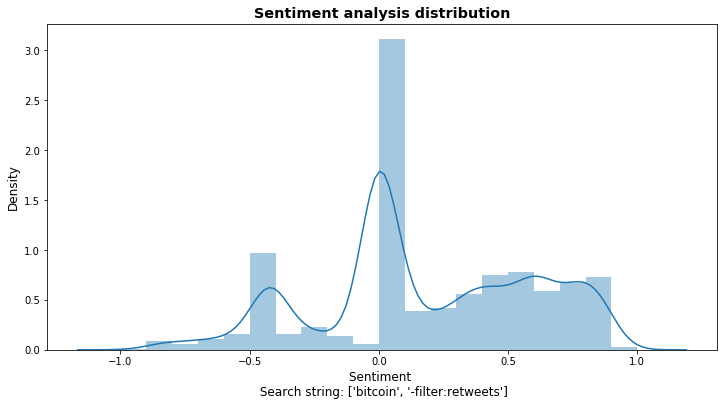

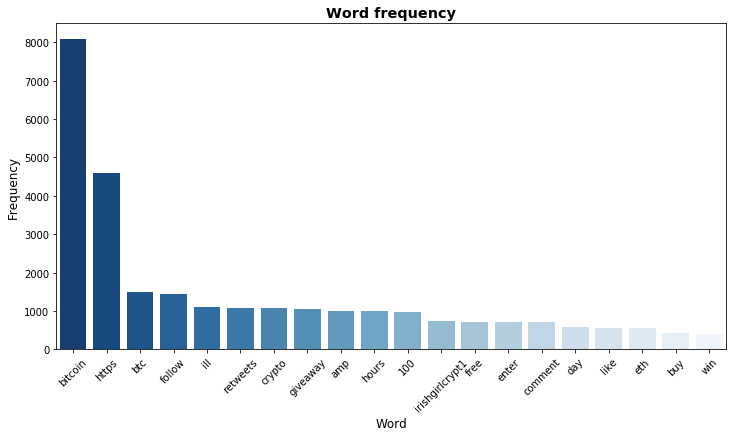

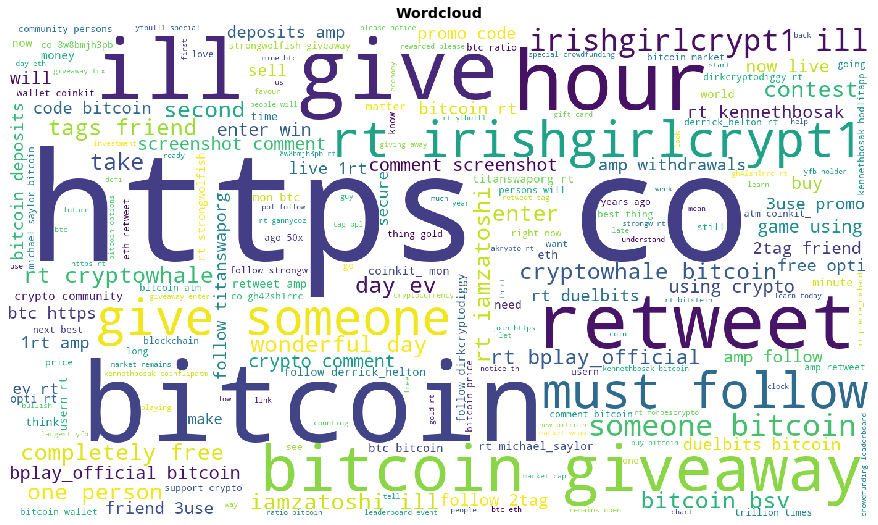

In [17]:
plot_sentiment(df)
plot_wordfreq(df)
plot_wordcloud(df)